# Memory experiment on an extended logical qubit

This notebook aims at performing a memory experiment on an extended logical qubit (see image below).

![A logical qubit that has been extended horizontally by 2 plaquettes](./images/extended_logical_qubit.png)

## Mandatory imports

In [1]:
import cirq
import matplotlib.pyplot as plt
import sinter
import stim
from stimcirq import cirq_circuit_to_stim_circuit

from tqec.templates.constructions.qubit import QubitRectangleTemplate
from tqec.templates.scale import Dimension, LinearFunction
from tqec.detectors.gate import ShiftCoordsGate
from tqec.detectors.transformer import fill_in_global_record_indices
from tqec.enums import PlaquetteOrientation
from tqec.generation.circuit import generate_circuit
from tqec.noise_models import (
    AfterCliffordDepolarizingNoise,
    AfterResetFlipNoise,
    BeforeMeasurementFlipNoise,
)
from tqec.plaquette.plaquette import PlaquetteList
from tqec.plaquette.library import (
    XXPlaquetteList,
    XXXXPlaquetteList,
    ZZPlaquetteList,
    ZZZZPlaquetteList,
)
from tqec.detectors.gate import ObservableGate, RelativeMeasurement
from tqec.position import Shape2D
from tqec.display import display_template

## Normalisation and noisyness

Once the quantum error correction circuit implemented, we still need to apply two passes to obtain a circuit ready to be translated by the `stimcirq`.

The first pass normalises the `cirq.Circuit` produced. This pass was performing several modifications before, but is now simply removing potential empty `cirq.Moment` instances from the `cirq.Circuit` instance.

The second pass applies the noise model(s) we want to consider in the `stim` simulation.

In [2]:
def normalise_circuit(circuit: cirq.Circuit) -> cirq.Circuit:
    ordered_transformers = [
        cirq.drop_empty_moments,
    ]
    for transformer in ordered_transformers:
        circuit = transformer(circuit)
    return circuit


def to_noisy_circuit(circuit: cirq.Circuit, noise_level: float) -> cirq.Circuit:
    noise_models = [
        AfterCliffordDepolarizingNoise(noise_level),
        AfterResetFlipNoise(noise_level),
        BeforeMeasurementFlipNoise(noise_level),
    ]
    for nm in noise_models:
        circuit = circuit.with_noise(nm)
    return circuit

## Building the Circuit instance

The main goal of the `tqec` library is to construct the `cirq.Circuit` instance representing the QEC experiment we are interested in. In this notebook, we want to perform a memory experiment on an "extended" logical qubit.

The different pre-defined Plaquette instances `XXPlaquetteList`, ... implement by default the memory experiment, so we can use them without worrying about the quantum circuits actually executed.

In [3]:
width, height = Dimension(4, LinearFunction(2)), Dimension(2, LinearFunction(2))
template = QubitRectangleTemplate(width, height)
display_template(template)

  .  .  1  .  1  .  1  .  1  .
  2  3  4  3  4  3  4  3  4  .
  .  4  3  4  3  4  3  4  3  5
  2  3  4  3  4  3  4  3  4  .
  .  4  3  4  3  4  3  4  3  5
  .  6  .  6  .  6  .  6  .  .


In [4]:
def generate_cirq_circuit_tqec(
    k_width: int, k_height: int, repetitions: int
) -> cirq.Circuit:
    # 1. Define the template.
    # Here, the template is directly constructed to the requested dimensions, so we do not need to
    # re-scale it using the Template.to_scale method.
    template = QubitRectangleTemplate(
        Dimension(k_width, LinearFunction(2)),
        Dimension(k_height, LinearFunction(2)),
    )

    # 2. Define the different plaquettes that will be used on the template defined above.
    # As noted in the text description above this function, the plaquette instances in the list below
    # implement by default the memory experiment we want to perform. That is the reason why there is no
    # tedious quantum circuit definition here.
    # The following time schedules are used accross plaquettes:
    # - Initial reset index is 1
    # - (H gate for X-stabilizers is 2)
    # - CNOTs indices are 3, 4, 5, 6
    # - (H gate for X-stabilizers is 7)
    # - Measurement index is 8
    plaquettes: list[PlaquetteList] = [
        XXPlaquetteList(
            PlaquetteOrientation.UP, [1, 2, 5, 6, 7, 8], include_detector=False
        ),
        ZZPlaquetteList(PlaquetteOrientation.LEFT, [1, 5, 6, 8]),
        XXXXPlaquetteList([1, 2, 3, 4, 5, 6, 7, 8], include_detector=False),
        ZZZZPlaquetteList([1, 3, 4, 5, 6, 8]),
        ZZPlaquetteList(PlaquetteOrientation.RIGHT, [1, 3, 4, 8]),
        XXPlaquetteList(
            PlaquetteOrientation.DOWN, [1, 2, 3, 4, 7, 8], include_detector=False
        ),
    ]

    # 3. Define the layer modifiers.
    # In the memory experiment, we want to repeat the second layer `repetitions` times in order to
    # let the experiment run for an extended period of time.
    # This is done by encapsulating the circuit generated for the second layer into a
    # cirq.CircuitOperation that natively supports repeting an operation efficiently, and that is
    # natively recognized by the `tqec` library.
    def make_repeated_layer(circuit: cirq.Circuit) -> cirq.Circuit:
        # Note: we do not care on which qubit it is applied, but we want a SHIFT_COORDS instruction
        #       to be inserted somewhere in the repetition loop. It is inserted at the beginning.
        any_qubit = next(iter(circuit.all_qubits()), None)
        assert (
            any_qubit is not None
        ), "Could not find any qubit in the given Circuit instance."
        circuit_to_repeat = (
            cirq.Circuit([ShiftCoordsGate(0, 0, 1).on(any_qubit)]) + circuit
        )
        repeated_circuit_operation = cirq.CircuitOperation(
            circuit_to_repeat.freeze()
        ).repeat(repetitions)
        return cirq.Circuit([repeated_circuit_operation])

    layer_modificators = {1: make_repeated_layer}

    # 4. Actually create the cirq.Circuit instance by concatenating the circuits generated
    # for each layers and potentially modified by the modifiers defined above.
    circuit = cirq.Circuit()
    for layer_index in range(3):
        layer_circuit = generate_circuit(
            template,
            [plaquette_list.plaquettes[layer_index] for plaquette_list in plaquettes],
        )
        layer_circuit = normalise_circuit(layer_circuit)
        circuit += layer_modificators.get(layer_index, lambda circ: circ)(layer_circuit)

    # 5. Define the observable.
    # The observable is defined and added to the cirq.Circuit instance just here.
    # We assume that each plaquette has the same shape (i.e., needs the same number of qubits on the X and
    # Y dimensions). XX and ZZ stabilizers have been artificially made 3x3 plaquettes for this purpose. This
    # assumption will eventually need to be lifted.
    plaquette_shape: Shape2D = plaquettes[0].plaquettes[0].shape
    assert all(
        p.shape == plaquette_shape
        for plaquette_list in plaquettes
        for p in plaquette_list.plaquettes
    ), "All plaquettes should have exactly the same shape for the moment."
    origin = cirq.GridQubit(
        (plaquette_shape.y - 1) * (1 + 2 * k_height // 2), plaquette_shape.x - 1
    )
    circuit.append(
        [
            ObservableGate(
                [
                    RelativeMeasurement(
                        cirq.GridQubit(0, i * (plaquette_shape.x - 1)), -1
                    )
                    for i in range(2 * k_width + 1)
                ],
            ).on(origin)
        ]
    )

    # 6. Due to limitations in the API provided by Stim, the DetectorGate and ObservableGate instances
    # in the circuit only contain local measurement records, an internal representation that is not
    # understood by Stim. The fill_in_global_record_indices function replaces these local measurement
    # records by global ones that are understood by Stim.
    circuit_with_detectors = fill_in_global_record_indices(circuit)
    return circuit_with_detectors

## Include noise level and a better API

In order to perform the experiement and to compute the error threshold for such an experiment, we need to be able to vary the noise applied to our circuit. Also, we would like to only have one input that controls both the width and the height, to be able to vary only that input.

The following function builds a template that is twice as large horizontally than vertically and applies the provided noise level to the whole circuit before translating the circuit to `Stim`.

In [5]:
def generate_stim_circuit_tqec(
    code_distance: int, noise_level: float, repetitions: int
) -> stim.Circuit:
    k = (code_distance - 1) // 2
    circuit = generate_cirq_circuit_tqec(2 * k, k, repetitions)
    if abs(noise_level) > 1e-12:
        circuit = to_noisy_circuit(circuit, noise_level)
    else:
        print(
            f"Warning: a noise level below 1e-12 ({noise_level}) has been detected. Noise is disabled. If this was intentional, please remove this code."
        )

    return cirq_circuit_to_stim_circuit(circuit)

## TQEC plots

We should finally be ready to perform the `stim` simulations and plot the results of our `tqec`-generated QEC memory experiment.

In [6]:
surface_code_tasks_tqec = [
    sinter.Task(
        circuit=generate_stim_circuit_tqec(d, noise, 3 * d),
        json_metadata={"d": d, "r": 3 * d, "p": noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in [0.001, 0.002, 0.005, 0.01, 0.012, 0.014]
]

collected_surface_code_stats_tqec: list[sinter.TaskStats] = sinter.collect(
    num_workers=20,
    tasks=surface_code_tasks_tqec,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=False,
)

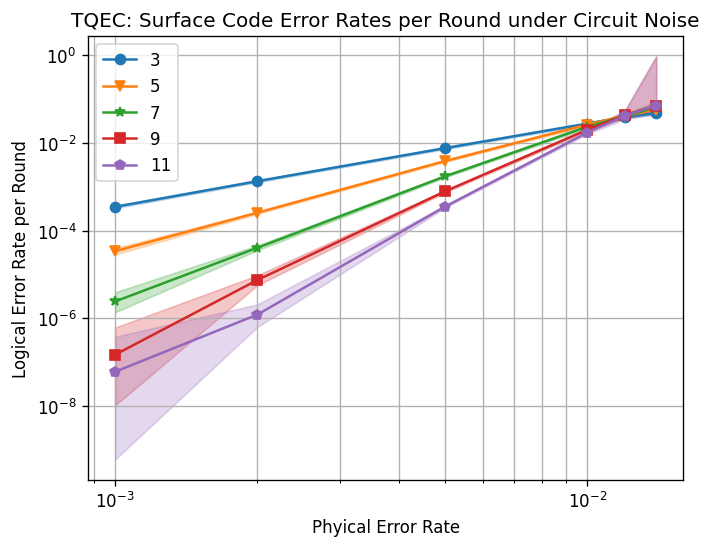

In [7]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_tqec,
    x_func=lambda stat: stat.json_metadata["p"],
    group_func=lambda stat: stat.json_metadata["d"],
    failure_units_per_shot_func=lambda stat: stat.json_metadata["r"],
)
ax.loglog()
ax.set_title("TQEC: Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger

## Circuit visualisation

Some debugging relicates that are left here if you want to visualise/compare the quantum circuits generated.

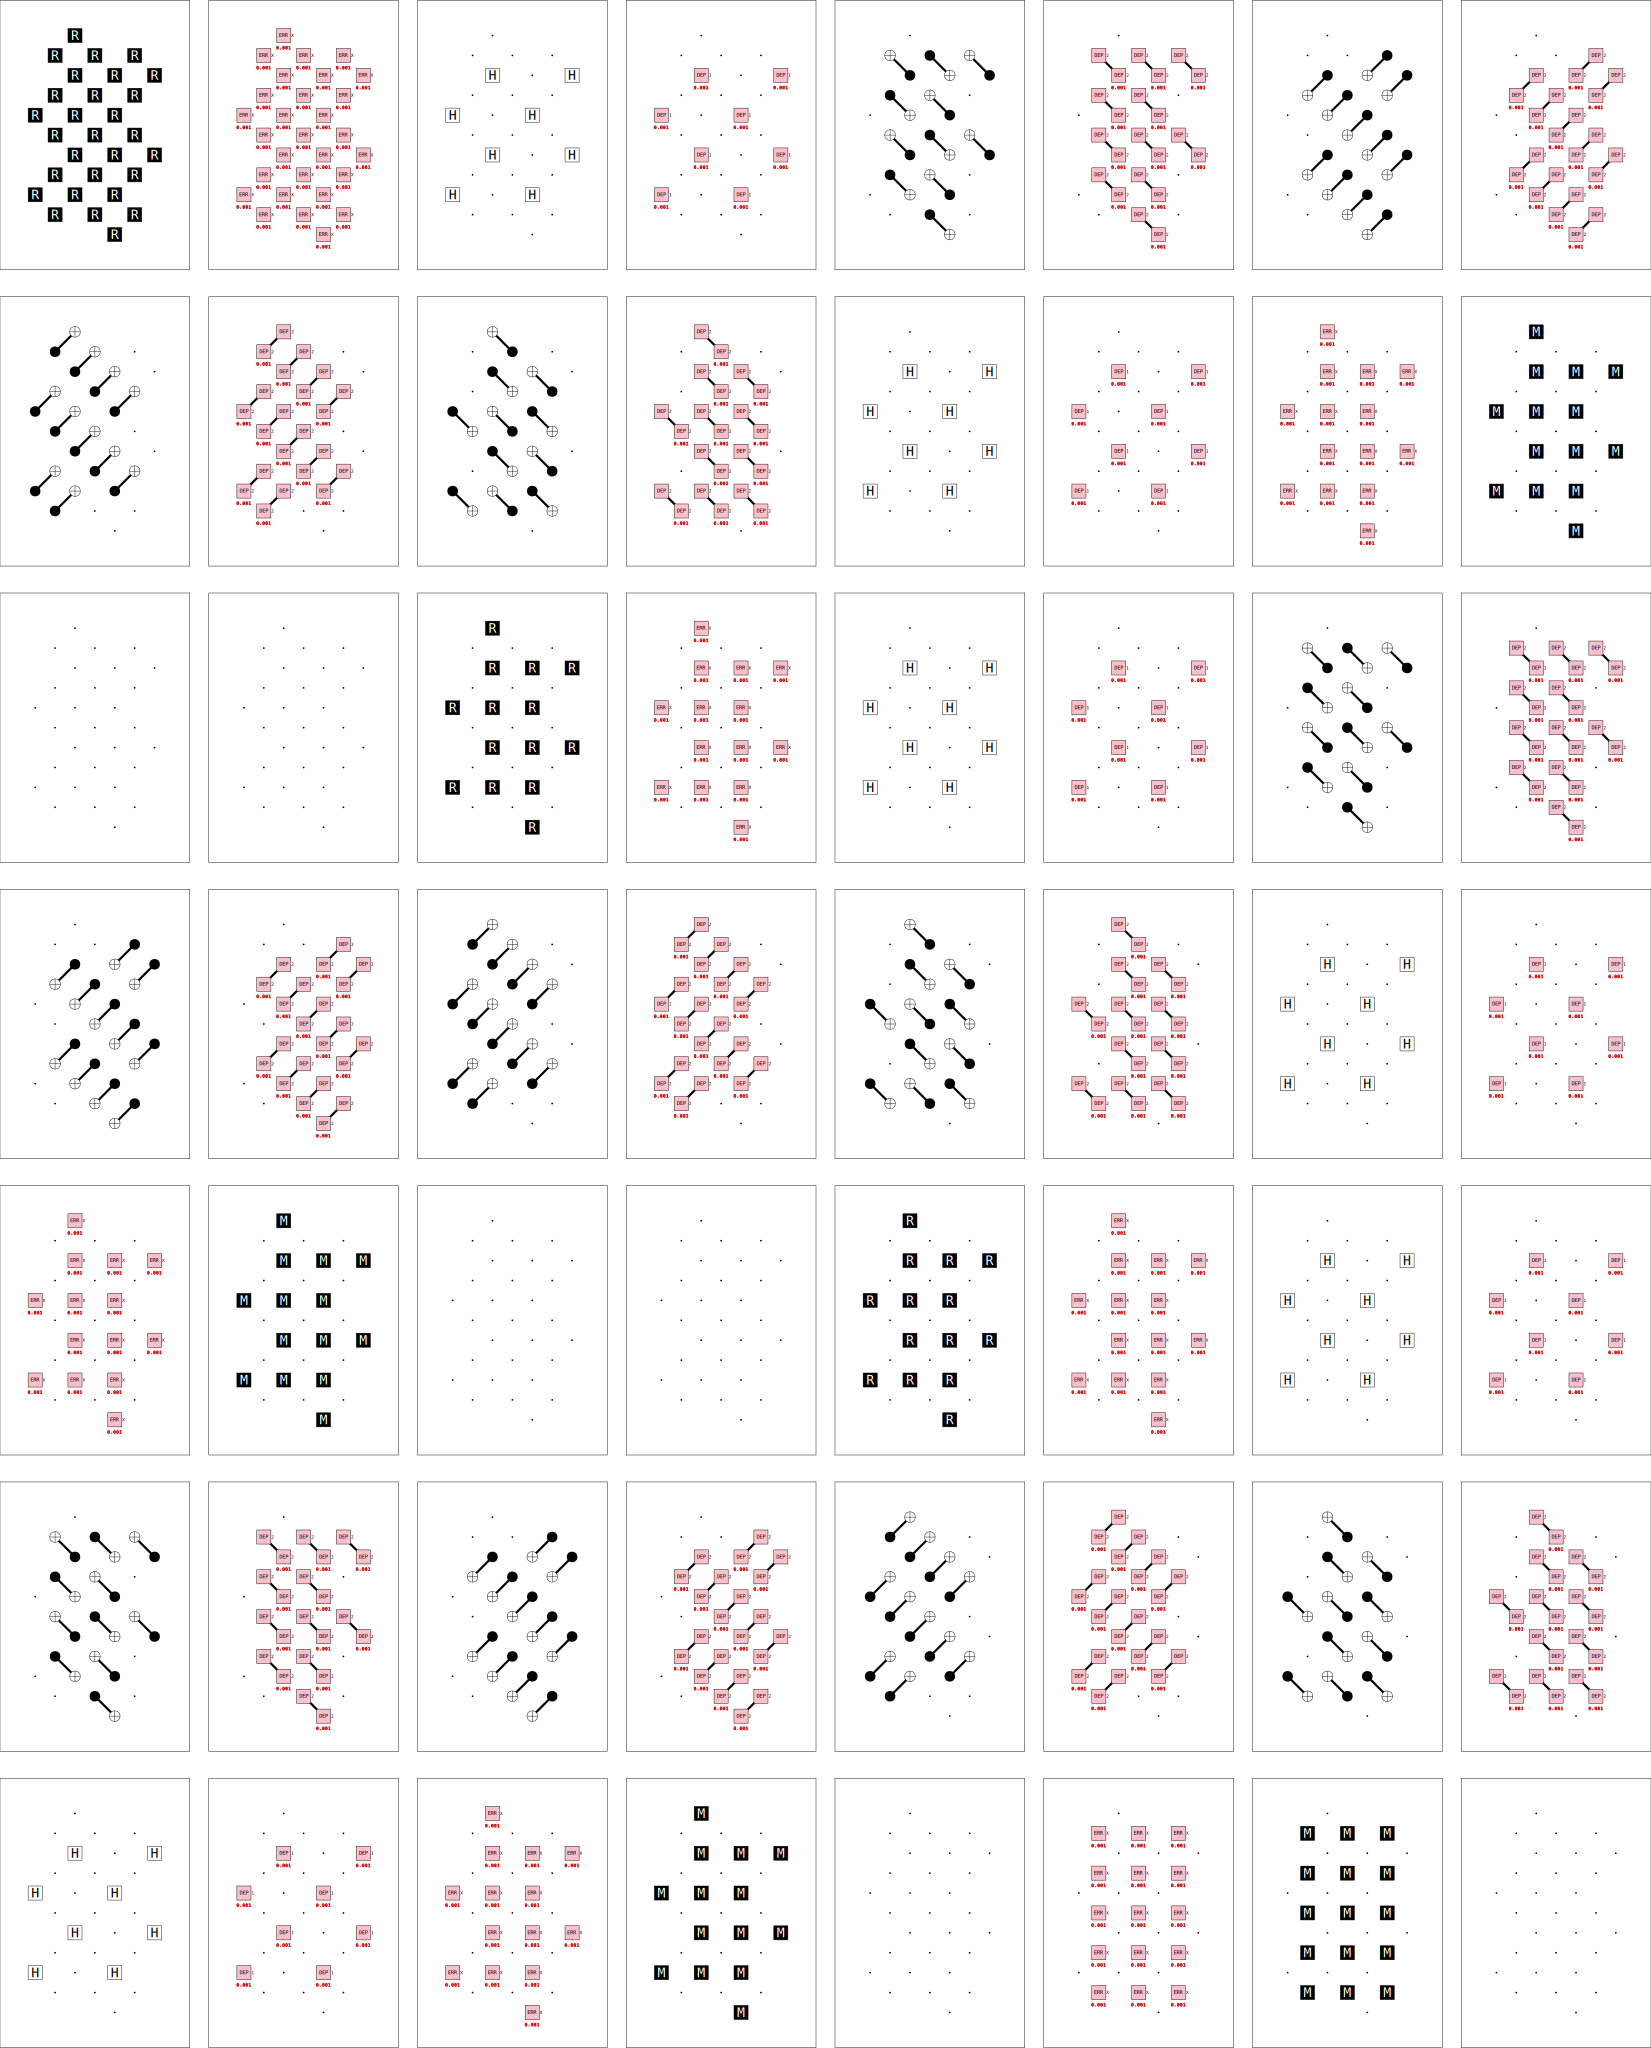

In [8]:
stim_circuit_tqec = generate_stim_circuit_tqec(3, 0.001, 2)
stim_circuit_tqec.diagram("timeslice-svg")